In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse.linalg as splin
import scipy.sparse as sparse
import scipy.sparse.linalg as splg
import json
import pickle


import random
import pandas as pd
import numpy as np

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import ndcg_score as ndcg

import torch

# data loading

In [2]:
dict_df_rating = dict()


#1 million MovieLens 

df_ratings = pd.read_csv('data/ml-1m/ratings.dat', sep="::", header=None)
df_ratings.columns = ['user_id', 'object_id', 'rating', 'timestamp']
df_ratings.index = list(range(len(df_ratings)))
df_ratings.drop('timestamp', axis='columns', inplace=True)
df_ratings.dropna(inplace=True)
df_ratings['user_id'] = df_ratings['user_id'].astype("category").cat.codes
df_ratings['object_id'] = df_ratings['object_id'].astype("category").cat.codes

dict_df_rating['ML1M'] = dict()
dict_df_rating['ML1M']['original'] = df_ratings

#Books http://www2.informatik.uni-freiburg.de/~cziegler/BX/

#df_ratings = pd.read_csv('data/Books Data/BX-Book-Ratings.csv', sep=';')
df_ratings = pd.read_csv('data/Books Data/BX-Book-Ratings_short.csv', sep=';')
df_ratings.columns = ['user_id', 'object_id', 'rating']
df_ratings.index = list(range(len(df_ratings)))
df_ratings.dropna(inplace=True)
df_ratings['user_id'] = df_ratings['user_id'].astype("category").cat.codes
df_ratings['object_id'] = df_ratings['object_id'].astype("category").cat.codes


dict_df_rating['BX'] = dict()
dict_df_rating['BX']['original'] = df_ratings

#Music  http://jmcauley.ucsd.edu/data/amazon/

#df_ratings = pd.read_csv('Digital music/ratings_Digital_Music.csv', sep=',', header=None)
df_ratings = pd.read_csv('data/Digital music/ratings_Digital_Music_short.csv', sep=',', header=None)
df_ratings.columns = ['user_id', 'object_id', 'rating', 'timestamp']
df_ratings.index = list(range(len(df_ratings)))
df_ratings.drop('timestamp', axis='columns', inplace=True)
df_ratings.dropna(inplace=True)
df_ratings['user_id'] = df_ratings['user_id'].astype("category").cat.codes
df_ratings['object_id'] = df_ratings['object_id'].astype("category").cat.codes


dict_df_rating['DM'] = dict()
dict_df_rating['DM']['original'] = df_ratings

/cephfs/projects/psoker/.local/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [3]:
for ds in dict_df_rating:
    df_ratings = dict_df_rating[ds]['original']
    all_cells = df_ratings.object_id.nunique() * df_ratings.user_id.nunique()
    sparcity_rate = len(df_ratings) / all_cells
    print(f'sparcity for {ds} dataset: {sparcity_rate}')

sparcity for ML1M dataset: 0.044683625622312845
sparcity for BX dataset: 0.0027201861251949793
sparcity for DM dataset: 0.0014640480404597422


print all possible ratings 

In [4]:
for ds in dict_df_rating:
    df_ratings = dict_df_rating[ds]['original']
    print(ds, df_ratings.rating.unique())

ML1M [5 3 4 2 1]
BX [10  9  5  8  6  2  7  3  4  1]
DM [5. 3. 4. 1. 2.]


In [7]:
def train_test_split(df, user_col, item_col='object_id', test_size=0.5):
    random.seed(123)
    test_indices = []
    for user in df[user_col].unique():
        df1 = df[df[user_col] == user]
        test_ind = random.sample(df[item_col].index.tolist(), k=int(len(df1)*test_size))
        test_indices.extend(test_ind)
    print(len(set(test_indices)), len(test_indices))
    test_data = df.iloc[test_indices]
    train_data = df.drop(test_indices, axis=0)
    return train_data, test_data

def create_sparse(df, user_col, item_col, rating_col):
    print(df[rating_col].shape, df[user_col].nunique(), df_ratings[item_col].nunique())
    data_sparse = sparse.csr_matrix(
        (df[rating_col].values, 
        (df[user_col].values, df[item_col].values)
        )
    )

    return data_sparse

In [9]:
#forming train test splitting
for ds in dict_df_rating:
    df_ratings = dict_df_rating[ds]['original'].copy()
    
    train_data, test_data = train_test_split(df_ratings, 'user_id', item_col='object_id', test_size=0.3)
    
    inner_data = set(train_data.object_id.unique()) & set(test_data.object_id.unique())
    train_data = train_data.query("object_id in @inner_data")
    test_data = test_data.query("object_id in @inner_data")
    
    dict_df_rating[ds]['train_original'] = train_data
    dict_df_rating[ds]['test_original'] = test_data
    

257082 297398
19529 22223
13618 15466


In [10]:
#forming sparse matrixes train test
for ds in dict_df_rating:
    print(ds)
    train_data = dict_df_rating[ds]['train_original'] 
    test_data = dict_df_rating[ds]['test_original']
    
    train_sparse = create_sparse(train_data, 'user_id', 'object_id', 'rating')
    test_sparse = create_sparse(test_data, 'user_id', 'object_id', 'rating')
    
    dict_df_rating[ds]['train_sparse'] = train_sparse
    dict_df_rating[ds]['test_sparse'] = test_sparse

ML1M
(742646,) 6040 8367
(297346,) 6040 8367
BX
(61523,) 6014 8367
(22212,) 4884 8367
DM
(37603,) 4316 8367
(14855,) 3514 8367


In [11]:
#forming sparse matrixes

for ds in dict_df_rating:
    print(ds)
    df_ratings = dict_df_rating[ds]['original'].copy()
    
    rows = df_ratings['user_id'].astype("int")
    cols = df_ratings['object_id'].astype("int")

    ratings = df_ratings.rating.astype("int")
    
    data_sparse = sparse.csr_matrix((ratings, (rows, cols)), shape=(df_ratings.user_id.nunique(), 
                                                                df_ratings.object_id.nunique()), dtype='int32')
    
    dict_df_rating[ds]['sparse'] = data_sparse

ML1M
BX
DM


In [12]:
df_ratings

,user_id,object_id,rating
0,3082,0,5.0
1,4828,0,5.0
2,2870,0,5.0
3,2194,0,5.0
4,3435,0,3.0
...,...,...,...
59259,3042,8364,5.0
59260,3042,8365,5.0
59261,3290,8366,5.0
59262,1574,8366,4.0


In [13]:
for ds in dict_df_rating:
    print(ds, dict_df_rating[ds]['sparse'].shape)

ML1M (6040, 3706)
BX (6195, 4958)
DM (4838, 8367)


# Methods

In [14]:
def recommend(user_id, data_sparse, user_vecs, item_vecs):
    """Recommend items for a given user given a trained model
    
    Args:
        user_id (int): The id of the user we want to create recommendations for.
        
        data_sparse (csr_matrix): Our original training data.
        
        user_vecs (csr_matrix): The trained user x features vectors
        
        item_vecs (csr_matrix): The trained item x features vectors
        
        item_lookup (pandas.DataFrame): Used to map artist ids to artist names
        
        num_items (int): How many recommendations we want to return:
        
    Returns:
        recommendations (pandas.DataFrame): DataFrame with num_items artist names and scores
    
    """
  
    # Get all interactions by the user
    user_interactions = data_sparse[user_id,:].toarray()

    # We don't want to recommend items the user has consumed. So let's
    # set them all to 0 and the unknowns to 1.
    user_interactions = user_interactions.reshape(-1) + 1 #Reshape to turn into 1D array
    #user_interactions[user_interactions > 1] = 0

    # This is where we calculate the recommendation by taking the 
    # dot-product of the user vectors with the item vectors.
    rec_vector = (user_vecs[user_id,:] @ item_vecs.T).toarray()

    # Let's scale our scores between 0 and 1 to make it all easier to interpret.
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1, 1))[:,0]
    recommend_vector = user_interactions * rec_vector_scaled
   
    # Get all the artist indices in order of recommendations (descending) and
    # select only the top "num_items" items. 
    item_idx = np.argsort(recommend_vector)[::-1]

    objects = []
    scores = []

    # Loop through our recommended artist indicies and look up the actial artist name
    for idx in item_idx:
        objects.append(idx)
        scores.append(recommend_vector[idx])

    # Create a new dataframe with recommended artist names and scores
    recommendations = pd.DataFrame({'object_id': objects, 'score': scores})
    
    return recommendations

In [15]:
all_metrix_res_dict = dict()

for ds in dict_df_rating:
    all_metrix_res = pd.DataFrame([], index = ['Recall20', 'Recall50', 'NDCG100'])
    all_metrix_res_dict[ds] = all_metrix_res

## ALS


In [22]:
def als(sparse_data, alpha_val=40, iterations=10, lambda_val=0.1, features=10):


    assert type(sparse_data) == sparse.csr_matrix, "Matrix should be sparse in format of csr"
    
    # Get the size of user rows and item columns
    frob = splg.norm(sparse_data, 'fro')
    mask = sparse_data.copy()
    mask[mask != 0] = 1
    res_l = []
    
    user_size, item_size = sparse_data.shape
    
    # We create the user vectors X of size users-by-features, the item vectors
    # Y of size items-by-features and randomly assign the values.
    X = sparse.csr_matrix(np.random.normal(size = (user_size, features)))
    Y = sparse.csr_matrix(np.random.normal(size = (item_size, features)))

    I = sparse.eye(features)
    lI = lambda_val * I
    
    for iter_ in tqdm(range(iterations)):
        
        # Precompute Y-transpose-Y and X-transpose-X
        yTy = Y.T @ Y

        # Loop through all users
        for u in range(user_size):
            u_row = sparse_data[u,:].toarray()
            #print(((yTy + lI).shape, (u_row @ Y).T.shape))
            X[u] = spsolve(yTy + lI, (u_row @ Y).T)
            
        xTx = X.T @ X
        for i in range(item_size):
            i_row = sparse_data[:,i].T.toarray()
            Y[i] = spsolve(xTx + lI, (i_row @ X).T)
            
        res_l.append(splg.norm((X @ Y.T).multiply(mask) - sparse_data, 'fro') / frob)
            
        with open(f'weights/als_vectors_{iter_}_iter_{lambda_val}_lambda_{ds}_correct.pickle', 'wb') as f:
            pickle.dump((X, Y, res_l), f)

    return X, Y, res_l

In [23]:
als_res_dict = dict()

for lambda_ in [0.01, 0.1, 0.3]:

    for ds in dict_df_rating:
        sparse_local = dict_df_rating[ds]['train_sparse']
        user_vecs, item_vecs, errors = als(sparse_local, iterations=10, features=20, lambda_val=lambda_)
        als_res_dict[ds] = (user_vecs, item_vecs, errors)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

# iALS

In [24]:
def implicit_ALS(train_sparse_data, alpha_val=40, iterations=10, lambda_val=0.1, features=10):
    assert type(train_sparse_data) == sparse.csr_matrix, "Matrix should be sparse in format of csr"
    
    # Calculate the foncidence for each value in our data
    confidence = train_sparse_data * alpha_val

    # Get the size of user rows and item columns
    user_size, item_size = train_sparse_data.shape

    frob = splg.norm(train_sparse_data, 'fro')
    
    mask = train_sparse_data.copy()
    mask[mask != 0] = 1
    res_l = []
    
    # We create the user vectors X of size users-by-self.features, the item vectors
    # Y of size items-by-self.features and randomly assign the values.
    X = sparse.csr_matrix(np.random.normal(size = (user_size, features)))
    Y = sparse.csr_matrix(np.random.normal(size = (item_size, features)))

    # Precompute I and lambda * I
    X_I = sparse.eye(user_size)
    Y_I = sparse.eye(item_size)

    I = sparse.eye(features)
    lI = lambda_val * I

    for iter_ in tqdm(range(iterations)):
        # Precompute Y-transpose-Y and X-transpose-X
        yTy = Y.T @ Y

        # Loop through all users
        for u in range(user_size):

            # Get the user row.
            u_row = confidence[u,:].toarray()
            
            # Calculate the binary preference p(u)
            p_u = u_row.copy()
            p_u[p_u != 0] = 1.0

            # Calculate Cu and Cu - I
            CuI = sparse.diags(u_row, [0])
            Cu = CuI + Y_I

            # Put it all together and compute the final formula
            yT_CuI_y = Y.T @ CuI @ Y
            yT_Cu_pu = Y.T @ Cu @ p_u.T
            X[u] = spsolve(yTy + yT_CuI_y + lI, yT_Cu_pu)

        xTx = X.T @ X
            
        for i in range(item_size):
            # Get the item column and transpose it.
            i_row = confidence[:,i].T.toarray()

            # Calculate the binary preference p(i)
            p_i = i_row.copy()
            p_i[p_i != 0] = 1.0

            # Calculate Ci and Ci - I
            CiI = sparse.diags(i_row, [0])
            Ci = CiI + X_I

            # Put it all together and compute the final formula
            xT_CiI_x = X.T @ CiI @ X
            xT_Ci_pi = X.T @ Ci @ p_i.T
            Y[i] = spsolve(xTx + xT_CiI_x + lI, xT_Ci_pi)
            
        res_l.append(splg.norm((X @ Y.T).multiply(mask) - train_sparse_data, 'fro') / frob)
        #print(res_l)
        with open(f'weights/ials_vectors_{iter_}_iter_{lambda_val}_lambda_{ds}_correct.pickle', 'wb') as f:
            pickle.dump((X, Y, res_l), f)
        
    return X, Y

In [25]:
ials_res_dict = dict()

for lambda_ in [0.01, 0.1, 0.3]:
    for ds in dict_df_rating:
        sparse_local = dict_df_rating[ds]['train_sparse']
        user_vecs, item_vecs = implicit_ALS(sparse_local, iterations=10, features=20, lambda_val=lambda_)
        ials_res_dict[ds] = (user_vecs, item_vecs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

# ALS with bias

In [26]:
def biased_als(sparse_data, iterations, lmbda, features):
    frob = splg.norm(sparse_data, 'fro')
    mask = sparse_data.copy()
    mask[mask != 0] = 1
    res_l = []

    user_size, item_size = sparse_data.shape
    
    X = sparse.csr_matrix(np.random.normal(size = (user_size, features+1)))
    Y = sparse.csr_matrix(np.random.normal(size = (features+1, item_size)))
    
    beta = np.zeros((1, user_size))
    gamma = np.zeros((1, item_size))
    
    X[:, 0] = beta
    Y[0, :] = gamma
    
    I = sparse.eye(features+1)
    lI = lmbda * I
    
    for iter_ in tqdm(range(iterations)):
        
        beta = X[:,0]
        beta = beta.reshape((1, -1))
        X_wave = X.copy()
        X_wave[:, 0] = np.ones((user_size, 1))
        Y[0, :] = gamma
        

        xTx = X_wave.T @ X_wave

        for i in range(item_size):
            
            r_i = sparse_data[:, i].T.toarray()
            r_i_beta = r_i - beta
            
            Y[:,i] = spsolve(xTx + lI, (r_i_beta @ X_wave).T)
        
        gamma = Y[0, :]
        Y_wave = Y.copy()
        Y_wave[0, :] = np.ones((1, item_size))
        X[:, 0] = beta.reshape(-1, 1)

        yTy = Y_wave @ Y_wave.T
        for u in range(user_size):
            r_u = sparse_data[u, :].toarray()
            r_u_gamma = r_u - gamma

            X[u,:] = spsolve(Y_wave @ Y_wave.T + lI, Y_wave @ r_u_gamma.T)
        
        res_l.append(splg.norm((X @ Y).multiply(mask) - sparse_data, 'fro') / frob)
        #print(res_l)
        with open(f'weights/als_bias_vectors_{iter_}_iter_{lmbda}_lambda_{ds}_correct.pickle', 'wb') as f:
            pickle.dump((X, Y, res_l), f)  
                     
    return X, Y.T

In [27]:
als_bias_res_dict = dict()

for lambda_ in [0.01, 0.1, 0.3]:
    for ds in dict_df_rating:
        sparse_local = dict_df_rating[ds]['train_sparse']
        user_vecs, item_vecs = biased_als(sparse_local, iterations=10, features=20, lmbda=lambda_)
        als_bias_res_dict[ds] = (user_vecs, item_vecs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

# Evaluation

In [28]:
def get_evaluation_bi(user_vecs, item_vecs, ds, method_name, threshold=0.7):
    df_ratings = dict_df_rating[ds]['test_original']
    all_users = df_ratings.user_id.unique()
    user_vecs_loc, item_vecs_loc = user_vecs, item_vecs
    sparse_local = dict_df_rating[ds]['test_sparse']

    rec20_list = []
    rec50_list = []
    NDCG_list = []
    multiplicator = 5 if ds != 'BX' else 10
    #print(threshold, multiplicator, multiplicator * threshold)

    for user_id in all_users:
        recommendations = recommend(user_id, sparse_local, user_vecs_loc, item_vecs_loc)
        dense_ratings_user = df_ratings[(df_ratings['user_id'] == user_id) & (df_ratings['rating'] > 0)]

        compilation = pd.merge(dense_ratings_user, recommendations, how='inner', on = 'object_id')

        if len(compilation) < 2:
            continue
        #dense_ratings_user.join(recommendations, on='object_id', how='inner')
        multiplicator = [5 if ds != 'BX' else 10][0]
        compilation['score']  = compilation.score * multiplicator
        compilation['score_bi']  = compilation['score'].apply(lambda x: 1 if x > threshold*multiplicator else 0)
        compilation['rating_bi'] = compilation['rating'].apply(lambda x: 1 if x > threshold*multiplicator else 0)
        compilation['score_round'] = round(compilation.score).astype(int)

        ratings = compilation.rating_bi.values
        scores = compilation.score_bi.values

        rec20 = recall(ratings, scores, k=20)
        rec50 = recall(ratings, scores, k=50)
        NDCG = ndcg(ratings.reshape((1, -1)), scores.reshape((1, -1)), k=100)

        rec20_list.append(rec20)
        rec50_list.append(rec50)
        NDCG_list.append(NDCG)

    metrix = []
    for lst in [rec20_list, rec50_list, NDCG_list]:
        metrix.append(np.mean(lst))

    all_metrix_res_dict[ds][method_name] = metrix
    
    return metrix, compilation
        

In [29]:
def recommend(user_id, data_sparse, user_vecs, item_vecs):
  
    # Get all interactions by the user
    user_interactions = data_sparse[user_id,:].toarray()

    # We don't want to recommend items the user has consumed. So let's
    # set them all to 0 and the unknowns to 1.
    user_interactions = user_interactions.reshape(-1) #Reshape to turn into 1D array
    #user_interactions[user_interactions > 1] = 0

    # This is where we calculate the recommendation by taking the 
    # dot-product of the user vectors with the item vectors.
    rec_vector = (user_vecs[user_id,:] @ item_vecs.T).toarray()

    # Let's scale our scores between 0 and 1 to make it all easier to interpret.
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1, 1))[:,0]
    recommend_vector = user_interactions * rec_vector_scaled
   
    # Get all the artist indices in order of recommendations (descending) and
    # select only the top "num_items" items. 
    item_idx = np.argsort(recommend_vector)[::-1]

    objects = []
    scores = []

    # Loop through our recommended artist indicies and look up the actial artist name
    for idx in item_idx:
        objects.append(idx)
        scores.append(recommend_vector[idx])

    # Create a new dataframe with recommended artist names and scores
    recommendations = pd.DataFrame({'object_id': objects, 'score': scores})
    

    return recommendations

In [30]:
def recall(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(len(act_set))
    return result

In [31]:
def recommend_correct(user_id, data_sparse, user_vecs, item_vecs):
  
    recommend_vector = (user_vecs[user_id,:] @ item_vecs.T).toarray().reshape(-1)
    print(recommend_vector)

    item_idx = np.argsort(recommend_vector)[::-1]
    print(item_idx)
    objects = []
    scores = []

    # Loop through our recommended artist indicies and look up the actial artist name
    for idx in item_idx:
        objects.append(idx)
        scores.append(recommend_vector[idx])

    # Create a new dataframe with recommended artist names and scores
    recommendations = pd.DataFrame({'object_id': objects, 'score': scores})

    return recommendations

In [ ]:
i = 10
lambda_val = 0.1
lambda_vals = [0.01, 0.1, 0.3]
trhs = [0.4, 0.6, 0.7]
iters = list(range(10))

columns_ = ['recall20', 'recall50', 'NDCG100', 'method', 'dataset', 'lambda_val', 'iterations', 'errors', 'thresholds']
results_models_ds_total = pd.DataFrame([], columns = columns_)
methods = ['als_bias']

for method in methods:
    for ds in dict_df_rating:
        print(method, ' ', ds)
        for iter_ in tqdm(range(10)):
            print(iter_)
            for i in tqdm(range(len(trhs))):
                trh = trhs[i]
                for lambda_val in lambda_vals:

                    with open(f'weights/{method}_vectors_{iter_}_iter_{lambda_val}_lambda_{ds}_correct.pickle', 'rb') as f:
                        user_vecs, item_vecs, errors = pickle.load(f)
                    
                    if method == 'als_bias':
                        item_vecs = item_vecs.T
                        
                    metrix, _ = get_evaluation_bi(user_vecs, item_vecs, ds, 'ALS', threshold=trh)
                    metrix.extend([method, ds, lambda_val, iter_+1, errors[-1], trh])

                    results_models_ds_total = results_models_ds_total.append(dict(zip(columns_, metrix)), ignore_index=True)
                    
            with open(f'weights/result_table_{method}_{ds}_{iter_}.pickle', 'wb') as f:
                pickle.dump(results_models_ds_total, f)


als_bias   ML1M


  0%|          | 0/10 [00:00<?, ?it/s]

0


  0%|          | 0/3 [00:00<?, ?it/s]

1


  0%|          | 0/3 [00:00<?, ?it/s]

2


  0%|          | 0/3 [00:00<?, ?it/s]

3


  0%|          | 0/3 [00:00<?, ?it/s]

4


  0%|          | 0/3 [00:00<?, ?it/s]

5


  0%|          | 0/3 [00:00<?, ?it/s]

6


  0%|          | 0/3 [00:00<?, ?it/s]

7


  0%|          | 0/3 [00:00<?, ?it/s]

8


  0%|          | 0/3 [00:00<?, ?it/s]

9


  0%|          | 0/3 [00:00<?, ?it/s]

als_bias   BX


  0%|          | 0/10 [00:00<?, ?it/s]

0


  0%|          | 0/3 [00:00<?, ?it/s]

1


  0%|          | 0/3 [00:00<?, ?it/s]

2


  0%|          | 0/3 [00:00<?, ?it/s]

3


  0%|          | 0/3 [00:00<?, ?it/s]

4


  0%|          | 0/3 [00:00<?, ?it/s]

5


  0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
method = 'als_bias'
ds = 'DM'
iter_ = 9
lambda_val

with open(f'metrics/result_table_{method}_{ds}_{iter_}.pickle', 'rb') as f:
    df_result = pickle.load(f)
    
df_result

,recall20,recall50,NDCG100,method,dataset,lambda_val,iterations,errors,thresholds
0,0.680944,0.725435,0.937646,als_bias,ML1M,0.01,1,0.909573,0.4
1,0.672908,0.715659,0.936668,als_bias,ML1M,0.10,1,0.929702,0.4
2,0.692295,0.735543,0.939903,als_bias,ML1M,0.30,1,0.946281,0.4
3,0.695526,0.755178,0.826419,als_bias,ML1M,0.01,1,0.909573,0.6
4,0.691798,0.748302,0.825207,als_bias,ML1M,0.10,1,0.929702,0.6
...,...,...,...,...,...,...,...,...,...
265,0.843775,0.845757,0.923339,als_bias,DM,0.10,10,0.902623,0.6
266,0.845559,0.847145,0.923458,als_bias,DM,0.30,10,0.902256,0.6
267,0.856463,0.858644,0.926436,als_bias,DM,0.01,10,0.902938,0.7
268,0.858247,0.860230,0.925945,als_bias,DM,0.10,10,0.902623,0.7


In [39]:
df_loc

,recall20,recall50,NDCG100,method,dataset,lambda_val,iterations,errors,thresholds
0,0.680944,0.725435,0.937646,als_bias,ML1M,0.01,1,0.909573,0.4
9,0.679702,0.720961,0.938061,als_bias,ML1M,0.01,2,0.829673,0.4
18,0.681690,0.723198,0.938137,als_bias,ML1M,0.01,3,0.817690,0.4
27,0.683347,0.727589,0.938276,als_bias,ML1M,0.01,4,0.814144,0.4
36,0.684341,0.729992,0.938469,als_bias,ML1M,0.01,5,0.812840,0.4
45,0.685336,0.731234,0.938544,als_bias,ML1M,0.01,6,0.812304,0.4
54,0.686827,0.731732,0.938560,als_bias,ML1M,0.01,7,0.812070,0.4
63,0.687241,0.732229,0.938539,als_bias,ML1M,0.01,8,0.811971,0.4
72,0.687490,0.732974,0.938579,als_bias,ML1M,0.01,9,0.811940,0.4
81,0.687158,0.731897,0.938555,als_bias,ML1M,0.01,10,0.811947,0.4


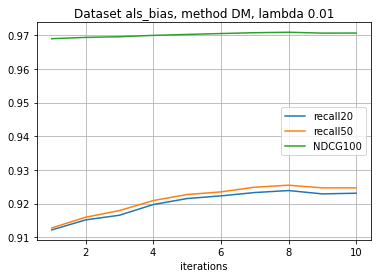

In [41]:
lambda_val = 0.01
thresholds = 0.4
ds = 'DM'

df_loc = df_result[(df_result.lambda_val == lambda_val) & \
                   (df_result.thresholds == thresholds) & \
                   (df_result.dataset == ds)
                  ]
plt.plot(df_loc.iterations, df_loc.recall20, label = 'recall20')
plt.plot(df_loc.iterations, df_loc.recall50, label = 'recall50')
plt.plot(df_loc.iterations, df_loc.NDCG100, label = 'NDCG100')
plt.legend()
plt.title(f'Dataset {method}, method {ds}, lambda {lambda_val}')
plt.xlabel('iterations')
plt.grid()
plt.show()

In [42]:
df_result.to_csv('metrics/df_final_metrics.csv', index=False)